# 10. QLS - Instability of Estimates

Whenever we consider a set of values, our calculation of a parameter can only be an estimate. It'll change as we take more measurements or as we get new values. We can quantify this uncertainty by looking at how the parameter changes as we look at different subsets of the data. By looking at how much the moving estimate fluctuates as we change our time period, we can compute the instability of the estimated parameter.

## Parameters

It's anything that models use make predictions. It's a quantity that helps to describe a data set. For example, the mean of a normal distribution is a parameter. Other parameters include the median, the correlation coefficient, the standard deviation, and every other measurement of a data set.

### You never know, you only estimate

When you take the mean of a data set, you don't know the true mean. The estimated mean is only as good as the data we have. It can be off. So it's important to know what is going on by determining how good our estimates are based on stability/standard error/confidence intervals.

In [52]:
import numpy as np
import pandas as pd
import seaborn as sb
import yfinance as yf

#### Example: Mean and Standard Deviation

We can take a look at some samples from a normal distribution. We know the mean is $0$ and the standard deviation is $1$; but if we measure the parameters from our observations, we'll get approximately $0$ and $1$. We can see how these change as we take more samples.

In [53]:
# set a seed, so we can play with the data without generating new random numbers every time
np.random.seed(123)

normal = np.random.randn(500)
print(np.mean(normal[:10]))
print(np.mean(normal[:100]))
print(np.mean(normal[:250]))
print(np.mean(normal))

-0.26951611032632805
0.027109073490359778
-0.020616059111720507
-0.038643973513210604


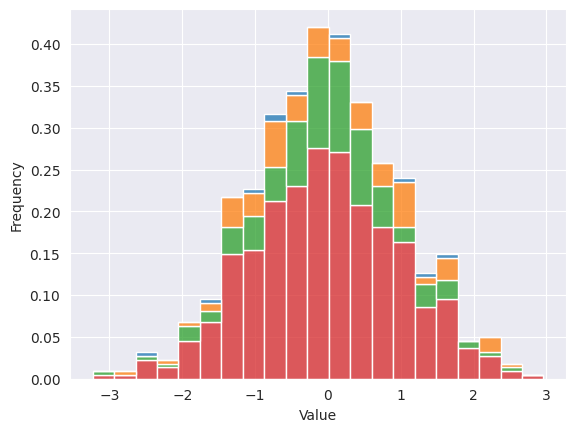

In [54]:
# plot a stacked histogram of the data
sb.histplot(data=[normal[:10], normal[10:100], normal[100:250], normal], stat="density", multiple="stack", legend=False).set(xlabel="Value", ylabel="Frequency");

Although the probability of getting closer to $0$ and $1$ (for the mean and deviation) increases with the number of samples, we don't always get better estimates by taking more data points. Whatever the expectation is, we'll always get a different result.

With time series data, we care only about contiguous subsets of the data. The moving average assigns the mean of the previous $n$ data points.

#### Example: Non-Normal Underlying Distribution

A mean will be very deceptive if the underlying data isn't normal. Because of this it's important to test for normality using a Jarque-Bera test.

Mean: 0.009847581282146528
Standard Deviation: 5.060708740105227


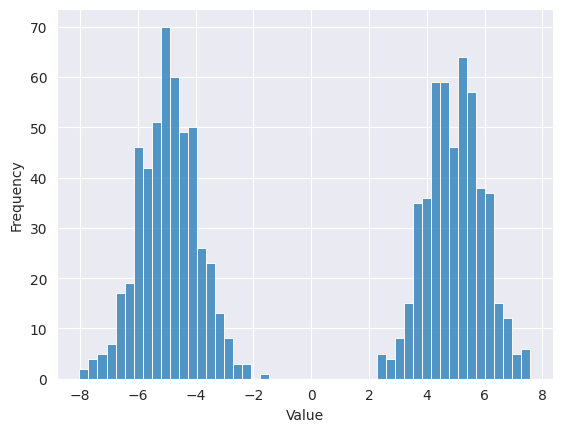

In [55]:
# generate some data from a bi-modal distribution
def bimodal(n):
    y = np.zeros(n)
    for i in range(n):
        if np.random.binomial(1, 0.5) == 0:
            y[i] = np.random.normal(-5, 1)
        else:
            y[i] =  np.random.normal(5, 1)
    return y

X = bimodal(1000)

# let's see how it looks
sb.histplot(X, bins=50).set(xlabel="Value", ylabel="Frequency")

print("Mean:", np.mean(X))
print("Standard Deviation:", np.std(X))

Sure enough, the mean isn't informative about what is going on in the data. We've collapsed all the data into an estimate, and lost a lot of info. This is what the distribution should look like if our hypothesis that it's normally distributed is true.

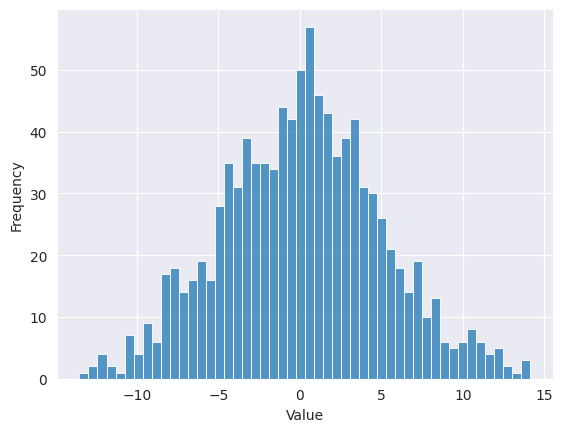

In [56]:
mu = np.mean(X)
sigma = np.std(X)

N = np.random.normal(mu, sigma, 1000)
sb.histplot(N, bins=50).set(xlabel="Value", ylabel="Frequency");

We'll test this using the Jarque-Bera test to see if it's normal. A significant p-value indicates non-normality.

In [57]:
from statsmodels.stats.stattools import jarque_bera
jarque_bera(X)

(142.12550136207705,
 1.3735343038981241e-31,
 -0.007644415681800414,
 1.1531707484649847)

The value is $<0.05$, and we say $X$ isn't normal. This saves us from making misinformed predictions.

#### Example: Sharpe Ratio

This measures the additional return per unit additional risk achieved by a portfolio, relative to a risk-free source of returns.

$$R = \frac{E[r_{a} - r_{b}]}{\sqrt{Var(r_{a} - r_{b})}}$$

Where $r_{a}$ is the returns on our asset and $r_{b}$ is the risk-free RoR. We can compute a rolling sharpe to see how an estimate changes over time.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


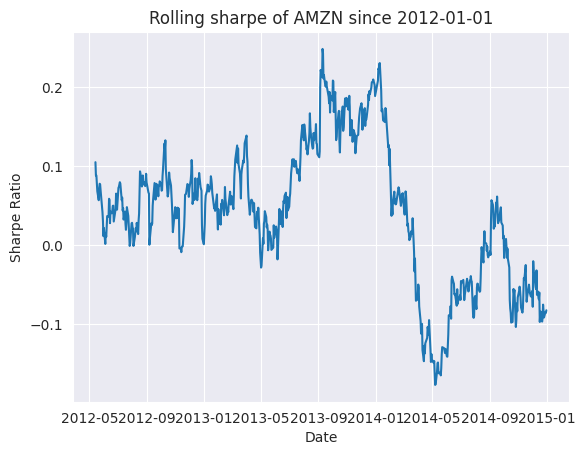

In [58]:
def sharpe_ratio(asset, riskfree):
    return np.mean(asset - riskfree)/np.std(asset - riskfree)

start = "2012-01-01"
end = "2015-01-01"
# use an ETF that tracks 10-year T-bills
treasury = yf.download("TLT", start, end)
pricing = yf.download("AMZN", start, end)

returns = pricing["Adj Close"].pct_change()[1:]
treasury_ret = treasury["Adj Close"].pct_change()[1:]

# calculate the rolling sharpe
running_sharpe = [sharpe_ratio(returns[i-90:i], treasury_ret[i-90:i]) for i in range(90, len(returns))]

sb.lineplot(x=returns.index[90:], y=running_sharpe).set(title=f"Rolling sharpe of AMZN since {start}", xlabel="Date", ylabel="Sharpe Ratio");

The Sharpe ratio looks volatile, and it's clear that reporting it as a single value isn't very helpful to predict future values. Instead, we can compute the mean and deviation to see if it can help us predict the sharpe for the next 100 days.

Mean of rolling sharpe: 0.05450195563800377
Standard deviation of rolling sharpe: 0.08790810264590873


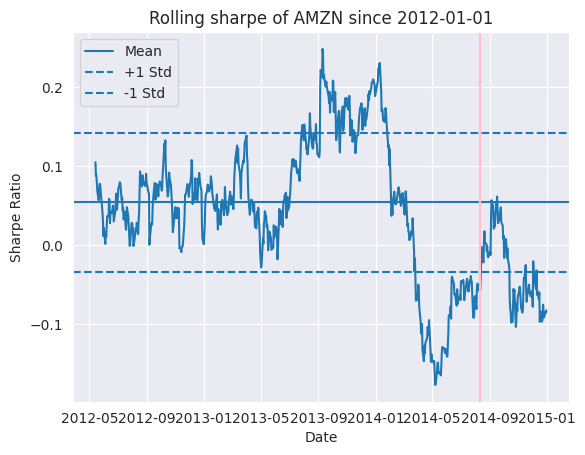

In [59]:
# compute the mean and std of the running sharpe up to 100 days before the end
mean_rs = np.mean(running_sharpe[:-100])
std_rs = np.std(running_sharpe[:-100])

# plot running sharpe
ax = sb.lineplot(x=returns.index[90:], y=running_sharpe)

# plot it's mean and the +/- 1 standard deviation lines
ax.axhline(mean_rs, label="Mean")
ax.axhline(mean_rs + std_rs, linestyle="--", label="+1 Std")
ax.axhline(mean_rs - std_rs, linestyle="--", label="-1 Std")
ax.axvline(returns.index[len(returns.index) - 100], color="pink")

# set title and labels
ax.set(title=f"Rolling sharpe of AMZN since {start}", xlabel="Date", ylabel="Sharpe Ratio")
ax.legend()

# get the values printed
print("Mean of rolling sharpe:", mean_rs)
print("Standard deviation of rolling sharpe:", std_rs)

The standard deviation is about a quarter of the range, so we can see it's very volatile. Looking ahead gave us a better prediction than just looking at the mean, although we still saw data more than one standard deviation away. We can also compute the rolling mean of the sharpe to try and follow trends; but we also need to keep in mind the standard deviation.

#### Example: Moving Average

Let's say we take the average with a lookback window; how do we determine the standard error on that estimate? Let's start with a 90-day moving average.

Mean of rolling mean: 14.419316972447318
StdDev of rolling mean: 2.5567575075803686


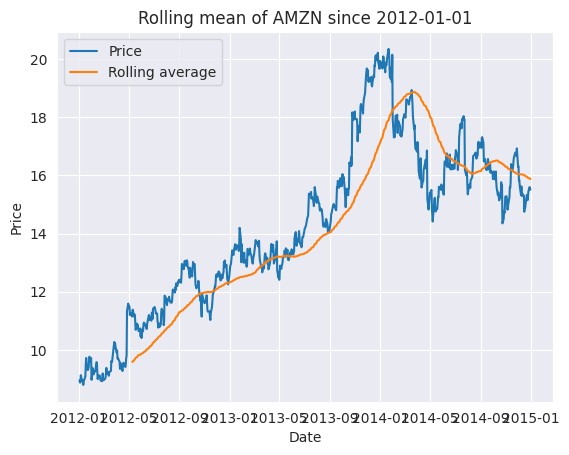

In [60]:
# compute the rolling mean for each day
mu = pricing["Adj Close"].rolling(90).mean()

# plot pricing data and rolling mean
sb.lineplot(x=pricing["Adj Close"].index, y=pricing["Adj Close"], label="Price")
sb.lineplot(x=pricing["Adj Close"].index, y=mu, label="Rolling average").set(title=f"Rolling mean of AMZN since {start}", xlabel="Date", ylabel="Price")

print("Mean of rolling mean:", np.mean(mu))
print("StdDev of rolling mean:", np.std(mu))

his lets us see the instability/standard error of the mean, and helps anticipate future variability in the data. In fact, the standard deviation, which we use to quantify variability, is itself variable. Below we plot the rolling standard deviation (for a 90-day window), and compute its mean and standard deviation.

Mean of rolling standard deviation: 0.8701913782700503
StdDev of rolling standard deviation: 0.3772346255500084


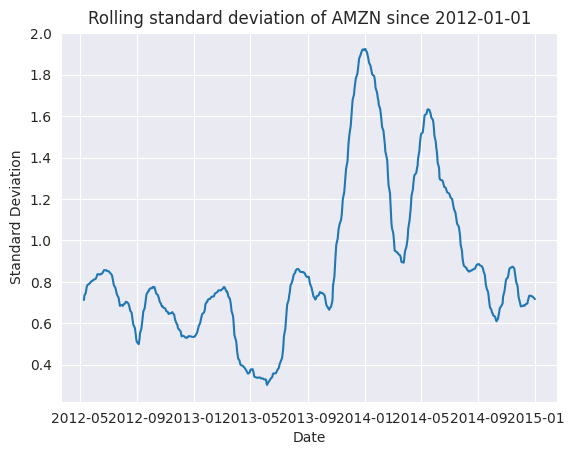

In [61]:
# compute the rolling standard deviation for each day
std = pricing["Adj Close"].rolling(90).std()

# plot pricing data and rolling mean
sb.lineplot(x=pricing["Adj Close"].index, y=std).set(title=f"Rolling standard deviation of AMZN since {start}", xlabel="Date", ylabel="Standard Deviation")

print("Mean of rolling standard deviation:", np.mean(std))
print("StdDev of rolling standard deviation:", np.std(std))

To see what this changing standard deviation means we can plot the prices again with Bollinger Bands (rolling mean, and rolling standard deviation bands). Note that although standard deviation gives us more info about the spread of the data, we can't assign precise probabilities to our expectations for the future without assuming a particular distribution.

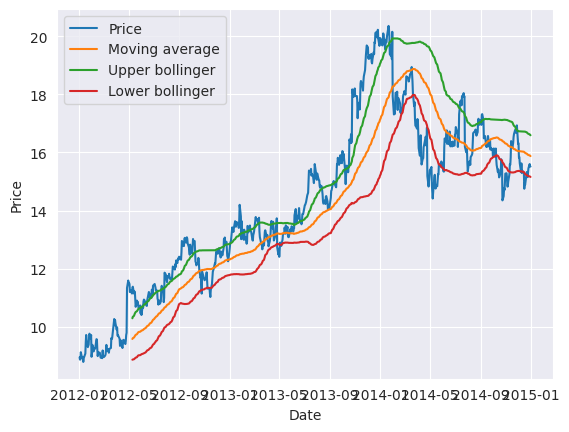

In [62]:
# compute the rolling mean for each day
mu = pricing["Adj Close"].rolling(90).mean()

# plot pricing data and rolling mean
sb.lineplot(x=pricing["Adj Close"].index, y=pricing["Adj Close"], label="Price")
sb.lineplot(x=pricing["Adj Close"].index, y=mu, label="Moving average")
sb.lineplot(x=pricing["Adj Close"].index, y=mu + std, label="Upper bollinger")
sb.lineplot(x=pricing["Adj Close"].index, y=mu - std, label="Lower bollinger").set(xlabel="Date", ylabel="Price");

Whenever we compute a parameter for a data set, we should also compute its volatility. Otherwise, we don't know if the values of the parameter will align to the values in the future. A good way to do this is by dividing the data into subsets and estimating the parameter from each one, then finding the variability between the results.